In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [3]:
# Read in data
df = pd.read_csv('/Users/annchen/Desktop/ESMT Berlin/Thesis/Data collection/Raw_data_final.csv',sep=";")
print(df.shape)

(4292, 7)


In [4]:
df.head()

,review_ID,product_name,category,star_rating,review_trans,helpfulness,unhelpful
0,1,DIOR Sauvage Eau de Parfum,Perfume,5,Vallah with an amg and this perfume you get ev...,674,155
1,2,DIOR Sauvage Eau de Parfum,Perfume,5,My sister had received a sample of it when she...,55,1
2,3,DIOR Sauvage Eau de Parfum,Perfume,5,Spray this perfume on your neck and stomach an...,88,39
3,4,DIOR Sauvage Eau de Parfum,Perfume,5,"My friend uses this perfume. In fact, the firs...",26,5
4,5,DIOR Sauvage Eau de Parfum,Perfume,5,Got it as a gift from my wife. Smells very goo...,14,1


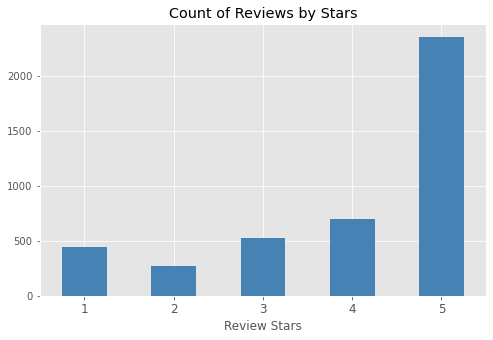

In [115]:
ax = df['star_rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(8, 5),
         color = 'steelblue'
         )
ax.set_xlabel('Review Stars')
ax.tick_params(axis='x', rotation=0, labelsize=12)

plt.show()

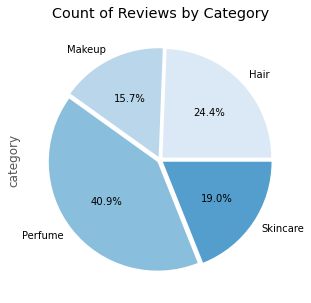

In [120]:
import matplotlib.pyplot as plt

categories = df['category'].value_counts().sort_index()

ax = categories.plot(kind='pie',
                     title='Count of Reviews by Category',
                     figsize=(8, 5),
                     autopct='%1.1f%%',
                    colors=sns.color_palette('Blues'),
                    explode=[0.03, 0.03, 0.03, 0.03])

plt.show()

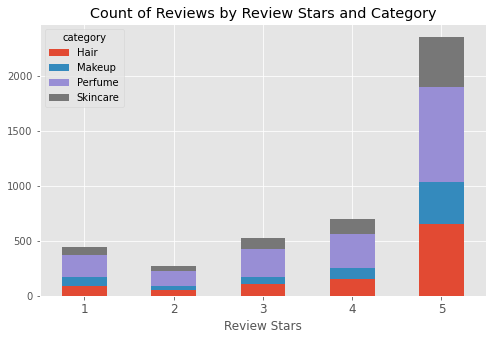

In [74]:
import matplotlib.pyplot as plt

ax = df.groupby(['star_rating', 'category']).size().unstack().plot(kind='bar',
                                                                   stacked=True,
                                                                   title='Count of Reviews by Review Stars and Category',
                                                                   figsize=(8, 5)
                                                                   )

ax.set_xlabel('Review Stars')
ax.tick_params(axis='x', rotation=0, labelsize=12)

plt.show()

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [6]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review_trans']
    myid = row['review_ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/4292 [00:00<?, ?it/s]

In [23]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'review_ID'})
vaders = vaders.merge(df, how='left')

In [20]:
vaders.head()

,review_ID,neg,neu,pos,compound,product_name,category,star_rating,review_trans,helpfulness,unhelpful
0,1,0.000,1.000,0.000,0.0000,DIOR Sauvage Esu de Parfum,Perfume,5,Vallah with an amg and this perfume you get ev...,674,155
1,2,0.082,0.802,0.116,0.2261,DIOR Sauvage Esu de Parfum,Perfume,5,My sister had received a sample of it when she...,55,1
2,3,0.041,0.811,0.148,0.7946,DIOR Sauvage Esu de Parfum,Perfume,5,Spray this perfume on your neck and stomach an...,88,39
3,4,0.106,0.658,0.235,0.7263,DIOR Sauvage Esu de Parfum,Perfume,5,"My friend uses this perfume. In fact, the firs...",26,5
4,5,0.000,0.683,0.317,0.7841,DIOR Sauvage Esu de Parfum,Perfume,5,Got it as a gift from my wife. Smells very goo...,14,1


In [24]:
ax = sns.barplot(data=vaders, x='star_rating', y='compound')
ax.set_title('Compound Score by Flaconi Star Review')
plt.show()

NameError: name 'vaders' is not defined

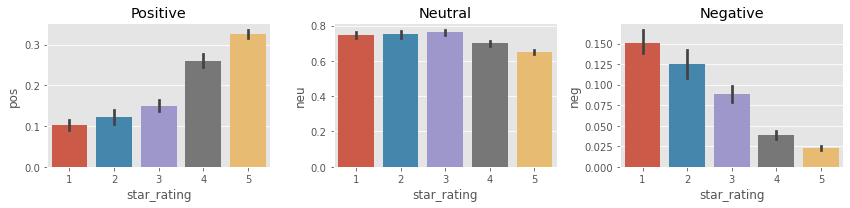

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='star_rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='star_rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='star_rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [7]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [8]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [9]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [10]:
res1 = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review_trans']
        myid = row['review_ID']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res1[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/4292 [00:00<?, ?it/s]

Broke for id 2761
Broke for id 2762
Broke for id 3104


In [11]:
results_df = pd.DataFrame(res1).T
results_df = results_df.reset_index().rename(columns={'index': 'review_ID'})
results_df = results_df.merge(df, how='left')

In [12]:
results_df.head()

,review_ID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,product_name,category,star_rating,review_trans,helpfulness,unhelpful
0,1,0.000,1.000,0.000,0.0000,0.124201,0.780885,0.094914,DIOR Sauvage Eau de Parfum,Perfume,5,Vallah with an amg and this perfume you get ev...,674,155
1,2,0.082,0.802,0.116,0.2261,0.003716,0.025665,0.970619,DIOR Sauvage Eau de Parfum,Perfume,5,My sister had received a sample of it when she...,55,1
2,3,0.041,0.811,0.148,0.7946,0.125804,0.438953,0.435242,DIOR Sauvage Eau de Parfum,Perfume,5,Spray this perfume on your neck and stomach an...,88,39
3,4,0.106,0.658,0.235,0.7263,0.002694,0.016121,0.981185,DIOR Sauvage Eau de Parfum,Perfume,5,"My friend uses this perfume. In fact, the firs...",26,5
4,5,0.000,0.683,0.317,0.7841,0.001090,0.021414,0.977497,DIOR Sauvage Eau de Parfum,Perfume,5,Got it as a gift from my wife. Smells very goo...,14,1


In [99]:
import pandas as pd

# Assuming results_df is your DataFrame
v_top_10 = results_df.nlargest(10, 'vader_pos')['review_trans']
v_low_10 = results_df.nlargest(10, 'vader_neg')['review_trans']
r_top_10 = results_df.nlargest(10, 'roberta_pos')['review_trans']
r_low_10 = results_df.nlargest(10, 'roberta_neg')['review_trans']

print(v_top_10)
print(v_low_10)
print(r_top_10)
print(r_low_10)

14       Super nice 👍
50      Strong, fresh
994        Fantastic!
1688              Top
1701              Top
1702             Cool
1736              Top
1745             good
1776             Good
1781        Wonderful
Name: review_trans, dtype: object
2130                                          no
3373                                        fake
1759                  Unfortunately not original
1577                                  Really bad
872                                 Bad smell...
1714                             Biggest failure
781                                 Totally weak
4225                                    Not good
2591                                Not original
2974    Packaging damaged. Mascara not original.
Name: review_trans, dtype: object
593     It was a very good-smelling perfume for my dea...
2850    My husband was very happy. The scent is wonder...
506     My grandmother smelled the perfume on me and w...
2009    My girlfriend and I are totally thrilled

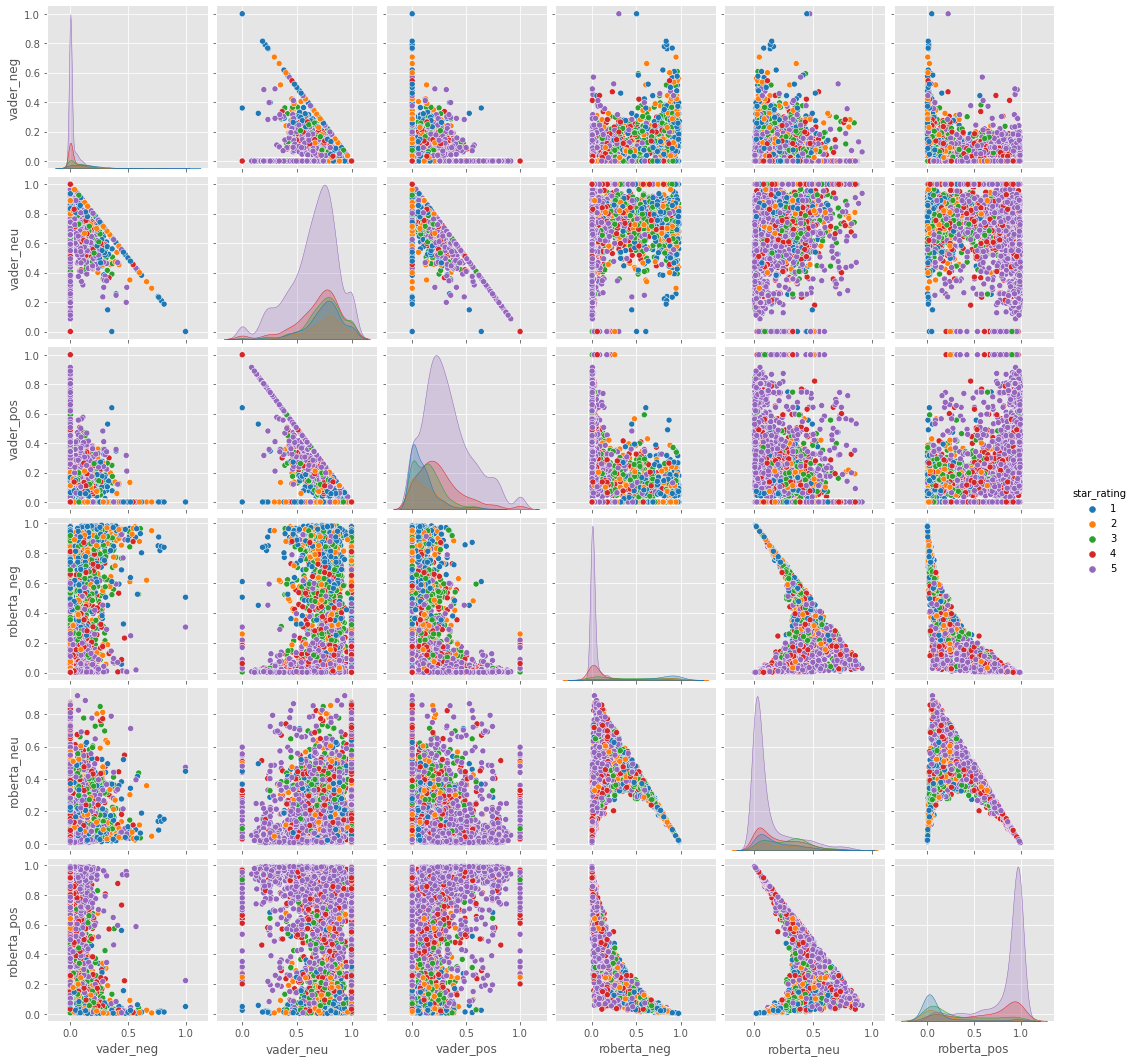

In [38]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='star_rating',
            palette='tab10')
plt.show()

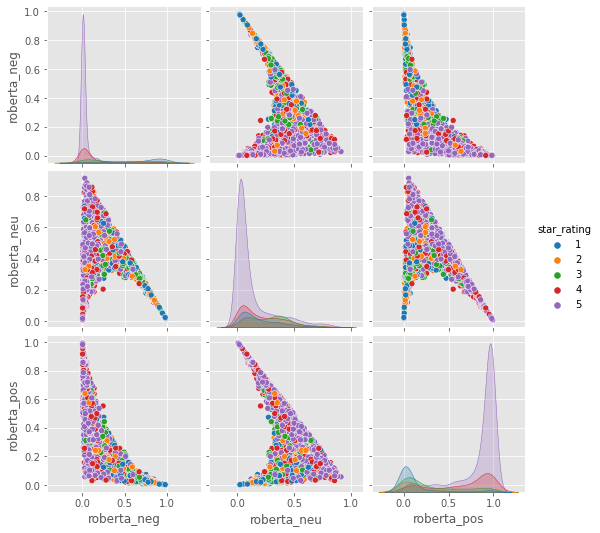

In [13]:
sns.pairplot(data=results_df,
             vars=[
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='star_rating',
            palette='tab10')
plt.show()

In [100]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming results_df is your DataFrame
correlation_matrix = results_df[["roberta_pos", "roberta_neu", "roberta_neg", "star_rating"]].corr()

p_values = []
for col1 in correlation_matrix.columns:
    p_values_row = []
    for col2 in correlation_matrix.columns:
        r, p = pearsonr(results_df[col1], results_df[col2])
        p_values_row.append(p)
    p_values.append(p_values_row)

p_values_df = pd.DataFrame(p_values, columns=correlation_matrix.columns, index=correlation_matrix.columns)

print("Correlation Matrix:")
print(correlation_matrix)
print("\nP-Values:")
print(p_values_df)

Correlation Matrix:
             roberta_pos  roberta_neu  roberta_neg  star_rating
roberta_pos     1.000000    -0.602714    -0.868672     0.690425
roberta_neu    -0.602714     1.000000     0.128264    -0.207425
roberta_neg    -0.868672     0.128264     1.000000    -0.729321
star_rating     0.690425    -0.207425    -0.729321     1.000000

P-Values:
             roberta_pos   roberta_neu   roberta_neg   star_rating
roberta_pos          0.0  0.000000e+00  0.000000e+00  0.000000e+00
roberta_neu          0.0  0.000000e+00  3.385031e-17  6.713686e-43
roberta_neg          0.0  3.385031e-17  0.000000e+00  0.000000e+00
star_rating          0.0  6.713686e-43  0.000000e+00  0.000000e+00


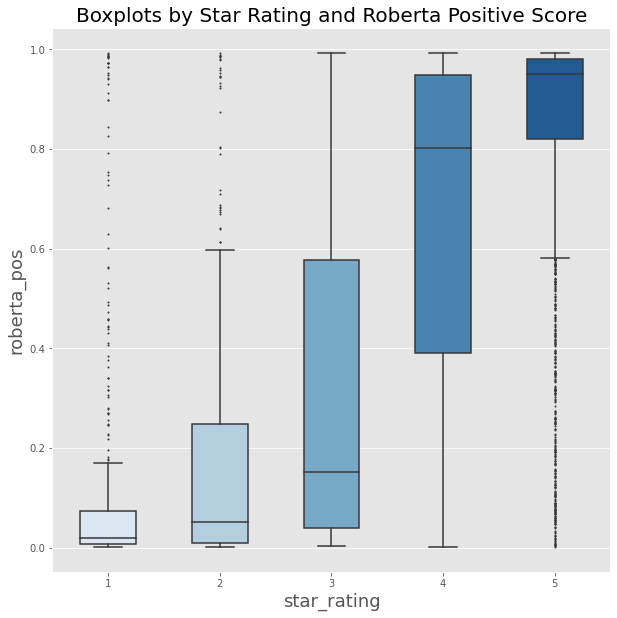

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results_df is your DataFrame
y_axis_column = "roberta_pos"
x_axis_column = "star_rating"

fig, ax = plt.subplots(figsize=(10, 10))

# Sort the unique ratings
sorted_ratings = sorted(results_df[x_axis_column].unique())

# Create the boxplot using seaborn
sns.boxplot(x=x_axis_column, y=y_axis_column, data=results_df, order=sorted_ratings, palette="Blues", width = 0.5,
             showfliers=True, flierprops=dict(marker='o', markerfacecolor='darkblue', markersize=1))


ax.set_xlabel(x_axis_column, size = 18)
ax.set_ylabel(y_axis_column, size = 18)
ax.set_title("Boxplots by Star Rating and Roberta Positive Score", size=20)

plt.show()


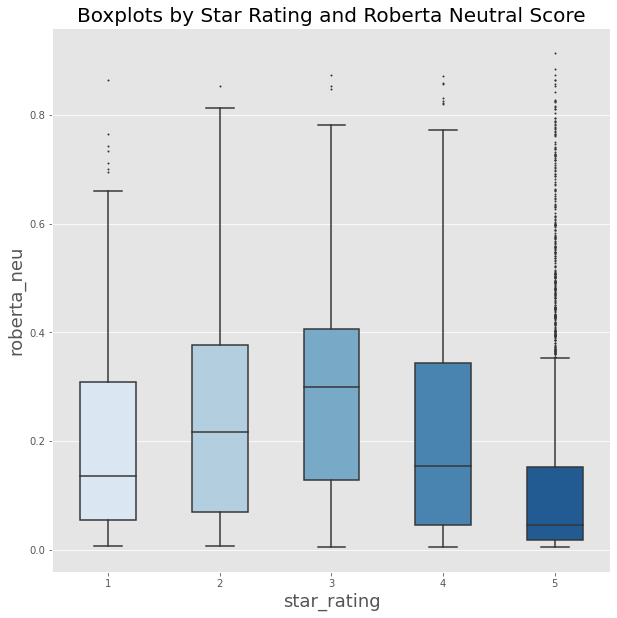

In [18]:
# Assuming results_df is your DataFrame
y_axis_column = "roberta_neu"
x_axis_column = "star_rating"

fig, ax = plt.subplots(figsize=(10, 10))

# Sort the unique ratings
sorted_ratings = sorted(results_df[x_axis_column].unique())

# Create the boxplot using seaborn
sns.boxplot(x=x_axis_column, y=y_axis_column, data=results_df, order=sorted_ratings, palette="Blues", width = 0.5,
             showfliers=True, flierprops=dict(marker='o', markerfacecolor='darkblue', markersize=1))


ax.set_xlabel(x_axis_column,size = 18)
ax.set_ylabel(y_axis_column,size = 18)
ax.set_title("Boxplots by Star Rating and Roberta Neutral Score",size = 20)

plt.show()

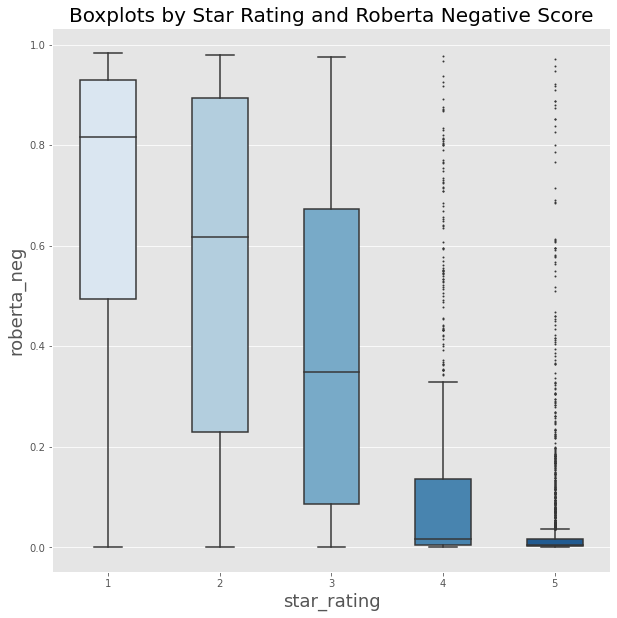

In [135]:
# Assuming results_df is your DataFrame
y_axis_column = "roberta_neg"
x_axis_column = "star_rating"

fig, ax = plt.subplots(figsize=(10, 10))

# Sort the unique ratings
sorted_ratings = sorted(results_df[x_axis_column].unique())

# Create the boxplot using seaborn
sns.boxplot(x=x_axis_column, y=y_axis_column, data=results_df, order=sorted_ratings, palette="Blues", width = 0.5,
            showfliers=True, flierprops=dict(marker='o', markerfacecolor='darkblue', markersize=1))


ax.set_xlabel(x_axis_column,size = 18)
ax.set_ylabel(y_axis_column,size = 18)
ax.set_title("Boxplots by Star Rating and Roberta Negative Score",size = 20)

plt.show()

In [136]:
import pandas as pd

# Assuming results_df is your DataFrame
dd_pos = results_df.groupby('star_rating')['roberta_pos'].describe()
dd_neu = results_df.groupby('star_rating')['roberta_neu'].describe()
dd_neg = results_df.groupby('star_rating')['roberta_neg'].describe()

print(dd_pos)
print(dd_neu)
print(dd_neg)

              count      mean       std       min       25%       50%  \
star_rating                                                             
1             445.0  0.121930  0.240579  0.001908  0.006868  0.020482   
2             274.0  0.188546  0.272604  0.001810  0.010448  0.051800   
3             521.0  0.311194  0.329330  0.002516  0.038892  0.151348   
4             699.0  0.659109  0.333261  0.001873  0.389985  0.801687   
5            2350.0  0.832562  0.247677  0.001897  0.820822  0.950127   

                  75%       max  
star_rating                      
1            0.072818  0.992050  
2            0.248104  0.992528  
3            0.577714  0.993442  
4            0.948467  0.993521  
5            0.980373  0.993263  
              count      mean       std       min       25%       50%  \
star_rating                                                             
1             445.0  0.195483  0.175206  0.006731  0.053715  0.134988   
2             274.0  0.252287  

In [139]:
# Combine the three DataFrames vertically
combined_df = pd.concat([dd_pos, dd_neu, dd_neg], axis=1)
# Rename the columns for better identification
combined_df.columns = ['roberta_pos_count','roberta_pos_mean', 'roberta_pos_std', 'roberta_pos_min', 'roberta_pos_25%', 'roberta_pos_50%', 'roberta_pos_75%', 'roberta_pos_max',
                       'roberta_pos_count','roberta_neu_mean', 'roberta_neu_std', 'roberta_neu_min', 'roberta_neu_25%', 'roberta_neu_50%', 'roberta_neu_75%', 'roberta_neu_max',
                       'roberta_pos_count','roberta_neg_mean', 'roberta_neg_std', 'roberta_neg_min', 'roberta_neg_25%', 'roberta_neg_50%', 'roberta_neg_75%', 'roberta_neg_max']

# Export the combined DataFrame to CSV
combined_df.to_csv('combined_output.csv', index=True)


              count      mean       std       min       25%       50%  \
star_rating                                                             
1             445.0  0.121930  0.240579  0.001908  0.006868  0.020482   
2             274.0  0.188546  0.272604  0.001810  0.010448  0.051800   
3             521.0  0.311194  0.329330  0.002516  0.038892  0.151348   
4             699.0  0.659109  0.333261  0.001873  0.389985  0.801687   
5            2350.0  0.832562  0.247677  0.001897  0.820822  0.950127   

                  75%       max   count      mean  ...       75%       max  \
star_rating                                        ...                       
1            0.072818  0.992050   445.0  0.195483  ...  0.307713  0.864974   
2            0.248104  0.992528   274.0  0.252287  ...  0.376900  0.854389   
3            0.577714  0.993442   521.0  0.290280  ...  0.405857  0.874541   
4            0.948467  0.993521   699.0  0.214263  ...  0.343959  0.872308   
5            0.98037

In [56]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")


In [57]:
def multi_scores(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'one_star' : scores[0],
        'two_star' : scores[1],
        'three_star' : scores[2],
        'four_star' : scores[3],
        'five_star' : scores[4],
    }
    return scores_dict

In [58]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review_trans']
        myid = row['review_ID']
        multi_result = multi_scores(text)
        res[myid] = multi_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/4292 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (935 > 512). Running this sequence through the model will result in indexing errors


Broke for id 2761
Broke for id 2762
Broke for id 3104
Broke for id 3945


In [62]:
bert_df = pd.DataFrame(res).T
bert_df = bert_df.reset_index().rename(columns={'index': 'review_ID'})
bert_df = bert_df.merge(df, how = 'left')

In [63]:
bert_df.head()

,review_ID,one_star,two_star,three_star,four_star,five_star,product_name,category,star_rating,review_trans,helpfulness,unhelpful
0,1,0.105191,0.035854,0.037069,0.120718,0.701169,DIOR Sauvage Eau de Parfum,Perfume,5,Vallah with an amg and this perfume you get ev...,674,155
1,2,0.397361,0.337528,0.122343,0.072311,0.070457,DIOR Sauvage Eau de Parfum,Perfume,5,My sister had received a sample of it when she...,55,1
2,3,0.030318,0.026925,0.039090,0.188268,0.715400,DIOR Sauvage Eau de Parfum,Perfume,5,Spray this perfume on your neck and stomach an...,88,39
3,4,0.042688,0.075843,0.152256,0.361058,0.368156,DIOR Sauvage Eau de Parfum,Perfume,5,"My friend uses this perfume. In fact, the firs...",26,5
4,5,0.001100,0.001243,0.007331,0.187843,0.802484,DIOR Sauvage Eau de Parfum,Perfume,5,Got it as a gift from my wife. Smells very goo...,14,1
